In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import bisect

In [2]:
# constants
mm = 1e-3
ang = 1.0
mm = 1e7 * ang
deg = np.pi / 180.0

In [89]:
def rotation(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

class Ray:
    def __init__(self, p, d):
        self.p = np.array(p).reshape(3)
        self.d = np.array(d).reshape(3)
        
class Bin2d:
    def __init__(self, x0, y0, x1, y1):
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1        
        self.bins = [ [0.0 for i in range(x0, x1)] for j in range(y0, y1) ]
        
    def add(self, x, y, value):
        i = int(y-self.y0)
        j = int(x-self.x0)
        
        if i < 0 or j < 0:
            return
        
        if i >= self.y1-self.y0 or j >= self.x1-self.x0:
            return
        
        self.bins[i][j] += value
        
class Bin3d:
    def __init__(self, x0, y0, z0, x1, y1, z1):
        self.x0 = x0
        self.x1 = x1
        self.y0 = y0
        self.y1 = y1    
        self.z0 = z0
        self.z1 = z1
        self.bins = [ [ [0.0 for i in range(x0, x1)] for j in range(y0, y1) ] for k in range(z0, z1) ]
        
    def add(self, x, y, z, value):
        j = int(y-self.y0)
        i = int(x-self.x0)
        k = int(z-self.z0)
        
        if i < 0 or j < 0 or k < 0:
            return
        
        if j >= self.y1-self.y0 or i >= self.x1-self.x0 or k >= self.z1-self.z0:
            return
        
        self.bins[k][j][i] += value

class Source:
    def __init__(self, width, height, distance, wavelength, dx, dz, dLambda):
        self.width = width
        self.height = height
        self.distance = distance
        self.wavelength = wavelength
        self.dx = dx
        self.dz = dz
        self.dLambda = dLambda
        
    def sample_focal_points(self, n):
        dw = 0.5*self.width*np.random.rand(n)
        dh = 0.5*self.width*np.random.rand(n)        
        return [np.array([dw[i], -self.distance, dh[i]]) for i in range(n) ]
    
    def kmean(self):
        return np.array([0,1,0]) / self.wavelength
    
    def scatter_prob(self, focal_point, scatter_point, q, theta):
        R = rotation(theta)
        Rq = R.dot(q)
        
        khat = R.dot(scatter_point)-focal_point
        khat /= np.linalg.norm(khat)

        wavelength = -2*Rq.dot(khat) / np.linalg.norm(q)**2
        k = khat / wavelength
        #print(khat, wavelength)
        
        kf = khat/wavelength + Rq
        

        sigma2x = self.dx**2
        sigma2z = self.dz**2
        sigma2E = self.dLambda**2

        dk = k*self.wavelength-np.array([0, 1, 0])

        arg = dk**2 / np.array([sigma2x, sigma2E, sigma2z])

        return np.exp(-0.5*arg.sum()), kf
        
class CylindricalDetector:
    def __init__(self, radius, nx, ny):
        self.radius = radius
        self.nx = nx
        self.ny = ny
        
        self.dx = 2*np.pi*radius / nx
        self.dy = self.dx
        
        self.width = nx*self.dx
        self.height = ny*self.dy
        
    def intersect(self, ray):
        dx = ray.d[0]
        dy = ray.d[1]
        px = ray.p[0]
        py = ray.p[1]
        
        a = dx**2 + dy**2
        b = 2*(dx*py+dy*py)
        c = px**2 + py**2 - self.radius**2
        
        disc = b**2 - 4*a*c
        
        if disc <= 0:
            return None
        
        sqd = np.sqrt(disc)
        ia = 1/ a        
        return 0.5*ia*(-b-sqd), 0.5*ia*(-b+sqd)
    
    def coords(self, ray):
        t = self.intersect(ray)
        
        if t is None or t[1] < 0:
            return None
        
        p = ray.p + t[1]*ray.d
        
        y = int(p[2]/self.dy)
        
        # not x and y are swapped
        theta = np.arctan2(p[0], p[1])
        x = int(self.nx*theta/2/np.pi)
        
        return x,y
        
class Crystal:
    def __init__(self, center, covariance, a, mosaicity):
        self.a = np.array(a)
        self.b = np.linalg.inv(self.a)
        
        self.center = np.array(center).reshape(3)
        self.covariance = np.array(covariance)
        self.inv_cov = np.linalg.inv(self.covariance)
        
        self.mosaicity = mosaicity
        
    def sample_points(self, n):
        dx = np.array([np.sqrt(self.covariance[i,i]) for i in range(3)])
        lower = self.center - dx
        upper = self.center + dx
        points = []
        
        while len(points) != n:
            x = np.random.uniform(lower[0], upper[0], n-len(points))
            y = np.random.uniform(lower[1], upper[1], n-len(points))
            z = np.random.uniform(lower[2], upper[2], n-len(points))
            ps = [ np.array([x[i], y[i], z[i]]) for i in range(n-len(points)) ]
            
            for p in ps:                
                dp = (p-self.center).reshape(1,3)
                if dp.dot(self.inv_cov).dot(dp.transpose()).trace() <= 1.0:
                    points.append(p)
                    
        return points
        
    def q(self, h, k, l):
        return h*self.b[:,0] + k*self.b[:,1] + l*self.b[:,2]
    
    # sample q taking mosaicity into account
    def sample_qs(self, h, k, l, n):
        print("hkl", h, k, l)
        q0 = self.q(h, k, l)
        e1 = np.cross(q0, np.random.rand(3))
        e2 = np.cross(e1, q0)
        e1 /= np.linalg.norm(e1)
        e2 /= np.linalg.norm(e2)
        
        qs = []
        
        dq1 = np.random.normal(0,1,n)*self.mosaicity*np.linalg.norm(q0)
        dq2 = np.random.normal(0,1,n)*self.mosaicity*np.linalg.norm(q0)
        
        
        return [q0 + dq1[i]*e1 + dq2[i]*e2 for i in range(n) ]
    
def bragg_condition(ki, q):
    return bisect(lambda t: np.linalg.norm(rotation(t).dot(q)+ki)-np.linalg.norm(ki), 0, 180*deg)

In [102]:
s = Source(10*mm, 7*mm, 200*mm, 2.67*ang, 0.03*deg, 0.1*deg, 0.005)
c = Crystal([0,0,0], np.diag([2*mm,5*mm,10*mm])**2, np.diag([40*ang, 50*ang, 60*ang]), 0.01*deg)
d = CylindricalDetector(200*mm, 2500, 900)

[0.13563185 0.33448184 0.1       ]
153 110
0.49827298625132677
Exact Bragg condition 142.74469578790558
Bragg condition at frame  142.74469578790558
central scatter prob (1.0, array([0.13563185, 0.33448184, 0.1       ]))
hkl 4 -5 6
q0 [ 0.1 -0.1  0.1]


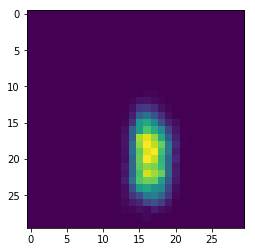

In [104]:
N = 5000000
dtheta = 0.2 * deg

h = 4
k = -5
l = 6

q0 = c.q(h, k, l)
k0 = s.kmean()
center = np.array([0,0,0])

exact = bragg_condition(k0, q0)/dtheta
#frame = int(exact)
frame=exact
R = rotation(frame*dtheta)
x0, y0 = d.coords(Ray(center, k0+R.dot(q0)))
print(k0+R.dot(q0))

print(x0, y0)
print(frame*dtheta)

nx = 15
ny = 15
nz = 5

bins = Bin2d(x0-nx, y0-ny, x0+nx, y0+nx)

print("Exact Bragg condition", bragg_condition(k0, q0)/dtheta)
print("Bragg condition at frame ", frame)
print("central scatter prob", s.scatter_prob(np.array([0,-1,0]), np.array([0,0,0]), q0, exact*dtheta))

qs = c.sample_qs(h, k, l, N)
ps = c.sample_points(N)
fs = s.sample_focal_points(N)

print("q0", q0)

df=-dtheta

for i in range(N):
    theta0 = (frame+df)*dtheta
    theta1 = (frame+df+1)*dtheta
    prob, kf = s.scatter_prob(fs[i], ps[i], qs[i], np.random.uniform(theta0, theta1))
    coords = d.coords(Ray(ps[i], kf))
    #print(coords, prob)
    bins.add(coords[0], coords[1], prob)
    
plt.imshow(bins.bins)
plt.show()

[181.1197359007804, 185.91379602767054, 4.227036311250581, 0.284328008132211, -0.004165969869464628, -0.004165969869464628, 0.08261393676860677]
 active_mask: array([0., 0., 0., 0., 0., 0., 0.])
        cost: 2908.953683662077
         fun: array([ 4.64855752e-24,  1.00195850e-21,  1.52373961e-19,  1.63493795e-17,
        1.23771680e-15,  6.61105538e-14,  2.49143637e-12,  6.62457923e-11,
        1.24278583e-09,  1.64499197e-08,  1.53624601e-07,  1.01224875e-06,
        4.70590577e-06,  1.54357842e-05,  3.57226498e-05,  5.83294833e-05,
        6.71988882e-05,  5.46217414e-05,  3.13255346e-05,  1.26753785e-05,
        3.61870247e-06,  7.28910679e-07,  1.03591768e-07,  1.03873717e-08,
        7.34878589e-10,  3.66821694e-11,  1.29188521e-12,  3.21012789e-14,
        5.62795011e-16,  6.96157713e-18,  1.65706831e-23,  3.60333061e-21,
        5.52837258e-19,  5.98439145e-17,  4.57058909e-15,  2.46294015e-13,
        9.36407825e-12,  2.51191943e-10,  4.75418275e-09,  6.34856447e-08,
        5

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in multiply


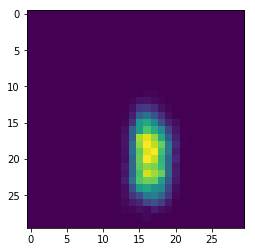

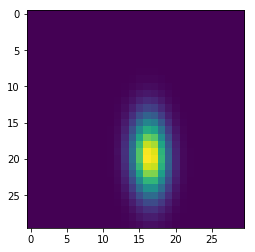

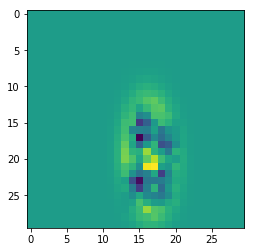

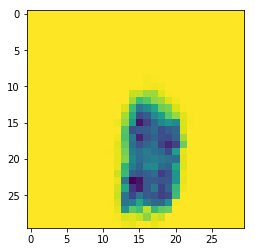

data sum 3804.332680125523
fit sum 4045.3856866984775


In [127]:
from scipy.optimize import least_squares

x = np.linspace(x0-nx, x0+nx, num=2*nx)
y = np.linspace(y0-ny, y0+ny, num=2*ny)

x, y = np.meshgrid(x, y)
data = np.array(bins.bins)


x0 = (x*data).sum() / data.sum()
y0 = (y*data).sum() / data.sum()
c = data.mean()

cxx = ((x-x0)**2*data).sum() / data.sum()
cxy = ((x-x0)*(y-y0)*data).sum() / data.sum()
cyy = ((y-y0)**2*data).sum() / data.sum()

C = np.array([cxx, cxy, cxy, cyy]).reshape(2,2)
C += np.identity(2)
A = np.linalg.inv(C)

axx = A[0,0]
axy = A[0,1]
ayy = A[1,1]

p0 = [x0, y0, c, axx, axy, axy, ayy]

print(p0)

def gauss(p):
    x0 = p[0]
    y0 = p[1]
    c = p[2]
    a = p[3:7].reshape(2,2)
    
    dx = x-x0
    dy = y-y0
    
    arg = a[0,0]*dx**2 + 2*a[0,1]*dx*dy + a[1,1]*dy**2
    return c*np.exp(-0.5*arg)

def residual(p): 
    return (gauss(p)-data).flatten()

result = least_squares(residual, np.array(p0))

print(result)
fit = gauss(result.x)

plt.imshow(data)
plt.show()

plt.imshow(fit)
plt.show()

plt.imshow((fit-data))
plt.show()

plt.imshow((fit-data)/fit)
plt.show()

print("data sum", data.sum())
print("fit sum", fit.sum())

In [128]:
data.transpose().dot(fit).trace() / np.linalg.norm(data) / np.linalg.norm(fit)

0.9864441975497142

In [ ]:
A = np.array([[1,2], [3,4]])
p = np.array([-1,1])
A.dot(p)

In [ ]:
R = rotation(2.0)
q = c.q(5,6,7)

print(q)
print(R.dot(q))

In [ ]:
kf = np.array([1., 1, 1])
kf /= np.linalg.norm(kf)
kf /= 2.67
ki = np.array([0, 1., 0])
ki /= 2.67
q = kf-ki
q.dot(np.linalg.inv(c.b))

In [ ]:
q = c.q(4, -5, 7)
np.linalg.norm(q)

In [ ]:
ki = np.array([0, 1., 0])
ki /= 2.67
q = c.q(4, -5, 7)

ks = []
ws = []

for i in range(360):
    R = rotation(i*deg)
    Rq = R.dot(q)
    kf = ki+Rq
    ks.append(np.linalg.norm(kf)/np.linalg.norm(ki))
    
    w = -2*Rq.dot(ki) / np.linalg.norm(ki) / np.linalg.norm(q)**2 / 2.67
    ws.append(w)
    
plt.plot(ks)
plt.show()

plt.plot(ws)
plt.show()

In [ ]:
bisect(lambda x: x**2+1, 0, 1)